In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import numpy as np
import pandas as pd
from pathlib import Path

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import models, transforms
from PIL import Image, ImageFile

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
)
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures

import matplotlib.pyplot as plt

ImageFile.LOAD_TRUNCATED_IMAGES = True

# ================================================================
# CONFIG
# ================================================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# --- Common class names (make sure these match your dirs / CSV) ---
AGE_CLASSES = [
    "Pre-school (3-6)",
    "Children (7-12)",
    "Teens (13-17)",
    "Young Adults (18-40)",
    "Adults (40-65)",
    "Seniors (65+)",
]
NUM_CLASSES = len(AGE_CLASSES)


age_groups_resnet = {
    "Pre-school (3-6)": "/content/drive/MyDrive/4995DLCV Final Project/Dataset/Pre-school (3-6)",
    "Children (7-12)": "/content/drive/MyDrive/4995DLCV Final Project/Dataset/Children (7-12)",
    "Teens (13-17)": "/content/drive/MyDrive/4995DLCV Final Project/Dataset/Teens (13-17)",
    "Young Adults (18-40)": "/content/drive/MyDrive/4995DLCV Final Project/Dataset/Young Adults (18-40)",
    "Adults (40-65)": "/content/drive/MyDrive/4995DLCV Final Project/Dataset/Adults (40-65)",
    "Seniors (65+)": "/content/drive/MyDrive/4995DLCV Final Project/Dataset/Seniors (65+)",
}

def load_items_for_split_resnet(age_groups, split_folder="test"):
    """
    Collect all (image_path, label_idx) for a given split (train/val/test or *_augment).
    """
    items = []
    image_extensions = ['.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff']

    for label_idx, (age_group_name, base_path) in enumerate(age_groups.items()):
        split_path = os.path.join(base_path, split_folder)
        if not os.path.exists(split_path):
            print(f"[ResNet] Split folder not found for {age_group_name}: {split_path}")
            continue
        files = [
            f for f in os.listdir(split_path)
            if any(f.lower().endswith(ext) for ext in image_extensions)
        ]
        for filename in files:
            items.append((os.path.join(split_path, filename), label_idx))
        print(f"[ResNet] {age_group_name:20s} {split_folder}: {len(files):4d} images")

    print(f"[ResNet] Total {split_folder} images: {len(items)}")
    return items

IMG_SIZE = 224
val_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

class AgeDataset(Dataset):
    def __init__(self, items, tf):
        self.items = items
        self.tf = tf

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        p, y = self.items[idx]
        try:
            img = Image.open(p).convert("RGB")
        except Exception as e:
            print(f"Error loading {p}: {e}")
            return self.__getitem__((idx + 1) % len(self.items))
        img = self.tf(img)
        return img, torch.tensor(y, dtype=torch.long)


BASE_VIT = Path("/content/drive/MyDrive/4995DLCV Final Project/Dataset")  # <<< CHECK PATH

AGE_CLASSES_VIT = [
    "Adults (40-65)",
    "Children (7-12)",
    "Pre-school (3-6)",
    "Seniors (65+)",
    "Teens (13-17)",
    "Young Adults (18-40)",
]
NUM_CLASSES_VIT = len(AGE_CLASSES_VIT)

class AgeHandwritingDataset(Dataset):
    def __init__(self, base_dir, split, transform=None):
        self.base_dir = Path(base_dir)
        self.split = split
        self.transform = transform

        self.class_names = AGE_CLASSES_VIT
        self.label_map = {cls_name: i for i, cls_name in enumerate(self.class_names)}
        self.samples = []

        exts = ("*.png", "*.jpg", "*.jpeg", "*.bmp", "*.JPG", "*.JPEG", "*.PNG")
        for cls_name in self.class_names:
            class_dir = self.base_dir / cls_name / split
            if not class_dir.exists():
                print(f"[ViT] Warning: folder not found: {class_dir}")
                continue
            for ext in exts:
                for img_path in class_dir.glob(ext):
                    self.samples.append((img_path, self.label_map[cls_name]))
        print(f"[ViT] [{split}] Found {len(self.samples)} images")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        try:
            img = Image.open(img_path).convert("RGB")
        except Exception:
            return self.__getitem__((idx + 1) % len(self.samples))

        if self.transform is not None:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.long)

vit_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225]),
])


# ResNet18
def build_resnet18(num_classes=NUM_CLASSES):
    m = models.resnet18(weights=None)
    in_features = m.fc.in_features
    m.fc = nn.Linear(in_features, num_classes)
    return m

# ResNet50
def build_resnet50(num_classes=NUM_CLASSES):
    m = models.resnet50(weights=None)
    in_features = m.fc.in_features
    m.fc = nn.Linear(in_features, num_classes)
    return m

#  ViT
try:
    from transformers import ViTModel
except ImportError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "transformers"])
    from transformers import ViTModel

class ViTAgeClassifier(nn.Module):
    def __init__(self, name="google/vit-base-patch16-224", num_classes=NUM_CLASSES_VIT):
        super().__init__()
        self.vit = ViTModel.from_pretrained(name)
        hidden = self.vit.config.hidden_size
        self.fc = nn.Linear(hidden, num_classes)
        for p in self.vit.parameters():
            p.requires_grad = False

    def forward(self, x):
        out = self.vit(pixel_values=x)
        cls = out.last_hidden_state[:, 0]
        logits = self.fc(cls)
        return logits

#  MLP on features
class MLP(nn.Module):
    def __init__(self, in_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, num_classes),
        )

    def forward(self, x):
        return self.net(x)


def evaluate_image_model(model, loader, num_classes, model_name="model"):
    model.eval()
    all_logits = []
    all_labels = []

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)
            logits = model(xb)
            all_logits.append(logits.cpu().numpy())
            all_labels.append(yb.cpu().numpy())

    all_logits = np.concatenate(all_logits)
    all_labels = np.concatenate(all_labels)

    probs = torch.softmax(torch.tensor(all_logits), dim=1).numpy()
    preds = probs.argmax(axis=1)

    acc = accuracy_score(all_labels, preds)
    macro_f1 = f1_score(all_labels, preds, average="macro")

    # Multi-class ROC-AUC (OvR)
    try:
        macro_auc = roc_auc_score(all_labels, probs, multi_class="ovr", average="macro")
    except ValueError:
        macro_auc = np.nan  # happens if some class missing in y_true

    cm = confusion_matrix(all_labels, preds)

    print(f"\n==== {model_name} ====")
    print(f"Accuracy:   {acc:.4f}")
    print(f"Macro F1:   {macro_f1:.4f}")
    print(f"Macro AUC:  {macro_auc:.4f}")
    print("Confusion matrix:\n", cm)

    return {
        "name": model_name,
        "accuracy": acc,
        "macro_f1": macro_f1,
        "macro_auc": macro_auc,
        "confusion_matrix": cm,
    }

def evaluate_feature_model(model, loader, num_classes, model_name="MLP"):
    model.eval()
    all_logits = []
    all_labels = []

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)
            logits = model(xb)
            all_logits.append(logits.cpu().numpy())
            all_labels.append(yb.cpu().numpy())

    all_logits = np.concatenate(all_logits)
    all_labels = np.concatenate(all_labels)

    probs = torch.softmax(torch.tensor(all_logits), dim=1).numpy()
    preds = probs.argmax(axis=1)

    acc = accuracy_score(all_labels, preds)
    macro_f1 = f1_score(all_labels, preds, average="macro")
    try:
        macro_auc = roc_auc_score(all_labels, probs, multi_class="ovr", average="macro")
    except ValueError:
        macro_auc = np.nan

    cm = confusion_matrix(all_labels, preds)

    print(f"\n==== {model_name} ====")
    print(f"Accuracy:   {acc:.4f}")
    print(f"Macro F1:   {macro_f1:.4f}")
    print(f"Macro AUC:  {macro_auc:.4f}")
    print("Confusion matrix:\n", cm)

    return {
        "name": model_name,
        "accuracy": acc,
        "macro_f1": macro_f1,
        "macro_auc": macro_auc,
        "confusion_matrix": cm,
    }


BATCH_SIZE = 32

resnet_test_items = load_items_for_split_resnet(
    age_groups_resnet,
    split_folder="test"
)
resnet_test_loader = DataLoader(
    AgeDataset(resnet_test_items, val_tf),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=(DEVICE.type == "cuda"),
)


vit_test_ds = AgeHandwritingDataset(BASE_VIT, "test", transform=vit_tf)
vit_test_loader = DataLoader(
    vit_test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=(DEVICE.type == "cuda"),
)

MASTER_CSV = "/content/drive/MyDrive/DLCV_HW5/Dataset/master_features_augmented.csv"  # <<< CHECK PATH
df = pd.read_csv(MASTER_CSV)

def infer_split(p):
    if "/train/" in p:
        return "train"
    elif "/test/" in p:
        return "val"
    elif "/val/" in p:
        return "test"
    else:
        return "unknown"

df["split"] = df["img_path"].apply(infer_split)

non_feature_cols = ["img_path", "age_class", "split"]
feature_cols = [c for c in df.columns if c not in non_feature_cols]

feat_df = df[feature_cols].copy()
feat_df = feat_df.replace([np.inf, -np.inf], np.nan)
mask_valid = ~feat_df.isna().any(axis=1)

df = df[mask_valid].reset_index(drop=True)
feat_df = feat_df[mask_valid].reset_index(drop=True)

le = LabelEncoder()
df["label"] = le.fit_transform(df["age_class"])
num_classes_mlp = len(le.classes_)
print("\n[MLP] Classes in CSV:", list(le.classes_))

X_raw = feat_df.values
y_all = df["label"].values
splits = df["split"].values

poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
X_poly = poly.fit_transform(X_raw)

X_train = X_poly[splits == "train"]
X_val   = X_poly[splits == "val"]
X_test  = X_poly[splits == "test"]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_t = torch.tensor(y_all[splits == "test"], dtype=torch.long)

mlp_test_loader = DataLoader(
    TensorDataset(X_test_t, y_test_t),
    batch_size=256,
    shuffle=False
)

input_dim_mlp = X_train_scaled.shape[1]
print("[MLP] Input dim:", input_dim_mlp)


results = []

resnet50_path = "/content/drive/MyDrive/4995DLCV Final Project/age_classifier_resnet50.pth"  # <<< CHECK PATH
resnet50 = build_resnet50(num_classes=NUM_CLASSES).to(DEVICE)
resnet50.load_state_dict(torch.load(resnet50_path, map_location=DEVICE))
results.append(
    evaluate_image_model(resnet50, resnet_test_loader, NUM_CLASSES, model_name="ResNet50")
)

resnet18_path = "/content/drive/MyDrive/4995DLCV Final Project/age_classifier_resnet18.pth"  # <<< CHECK PATH
resnet18 = build_resnet18(num_classes=NUM_CLASSES).to(DEVICE)
resnet18.load_state_dict(torch.load(resnet18_path, map_location=DEVICE))
results.append(
    evaluate_image_model(resnet18, resnet_test_loader, NUM_CLASSES, model_name="ResNet18")
)

vit_path = "/content/drive/MyDrive/4995DLCV Final Project/best_vit_age_classifier.pt"  # <<< CHECK PATH
vit_model = ViTAgeClassifier(num_classes=NUM_CLASSES_VIT).to(DEVICE)
vit_model.load_state_dict(torch.load(vit_path, map_location=DEVICE))
results.append(
    evaluate_image_model(vit_model, vit_test_loader, NUM_CLASSES_VIT, model_name="ViT")
)

mlp_path = "/content/drive/MyDrive/4995DLCV Final Project/best_mlp_poly_features.pt"  # <<< CHECK PATH
mlp_model = MLP(input_dim_mlp, num_classes_mlp).to(DEVICE)
mlp_model.load_state_dict(torch.load(mlp_path, map_location=DEVICE))
results.append(
    evaluate_feature_model(mlp_model, mlp_test_loader, num_classes_mlp, model_name="Features MLP")
)


print("\n================ SUMMARY (TEST) ================")
print(f"{'Model':20s}  {'Acc':>7s}  {'Macro-F1':>9s}  {'Macro-AUC':>9s}")
for r in results:
    print(f"{r['name']:20s}  {r['accuracy']:.4f}  {r['macro_f1']:.4f}  {r['macro_auc']:.4f}")
print("===============================================")


Using device: cuda
[ResNet] Pre-school (3-6)     test:  136 images
[ResNet] Children (7-12)      test:  104 images
[ResNet] Teens (13-17)        test:   69 images
[ResNet] Young Adults (18-40) test:   77 images
[ResNet] Adults (40-65)       test:  156 images
[ResNet] Seniors (65+)        test:   20 images
[ResNet] Total test images: 562
[ViT] [test] Found 562 images

[MLP] Classes in CSV: ['Adults (40-65)', 'Children (7-12)', 'Pre-school (3-6)', 'Seniors (65+)', 'Teens (13-17)', 'Young Adults (18-40)']
[MLP] Input dim: 2346

==== ResNet50 ====
Accuracy:   0.8310
Macro F1:   0.8393
Macro AUC:  0.9708
Confusion matrix:
 [[120  15   0   0   1   0]
 [ 31  70   0   1   2   0]
 [  0   0  58   6   5   0]
 [  0   3   5  46  23   0]
 [  0   0   0   3 153   0]
 [  0   0   0   0   0  20]]

==== ResNet18 ====
Accuracy:   0.7936
Macro F1:   0.8069
Macro AUC:  0.9687
Confusion matrix:
 [[123  12   0   0   1   0]
 [ 43  59   0   2   0   0]
 [  0   0  56   9   4   0]
 [  1   1   3  59  13   0]
 [  0  

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



==== ViT ====
Accuracy:   0.7313
Macro F1:   0.7095
Macro AUC:  0.9483
Confusion matrix:
 [[130   0   0   1   1  24]
 [  4  49  45   1   0   5]
 [  6  12 117   1   0   0]
 [  4   0   4  12   0   0]
 [  6   0   0   0  55   8]
 [ 17   1   0   0  11  48]]

==== Features MLP ====
Accuracy:   0.8625
Macro F1:   0.8732
Macro AUC:  0.9815
Confusion matrix:
 [[127   0   0   3   0  10]
 [  0  90  11   0   0   0]
 [  0  30 100   0   0   0]
 [  0   0   0  19   0   0]
 [  0   0   0   0  61   5]
 [ 13   0   0   0   1  61]]

================ SUMMARY (TEST) ================
Model                     Acc   Macro-F1  Macro-AUC
ResNet50              0.8310  0.8393  0.9708
ResNet18              0.7936  0.8069  0.9687
ViT                   0.7313  0.7095  0.9483
Features MLP          0.8625  0.8732  0.9815


          Model  Accuracy  Macro-F1  Macro-AUC
0      ResNet50  0.830961  0.839320   0.970797
1      ResNet18  0.793594  0.806900   0.968673
2           ViT  0.731317  0.709547   0.948320
3  Features MLP  0.862524  0.873233   0.981518


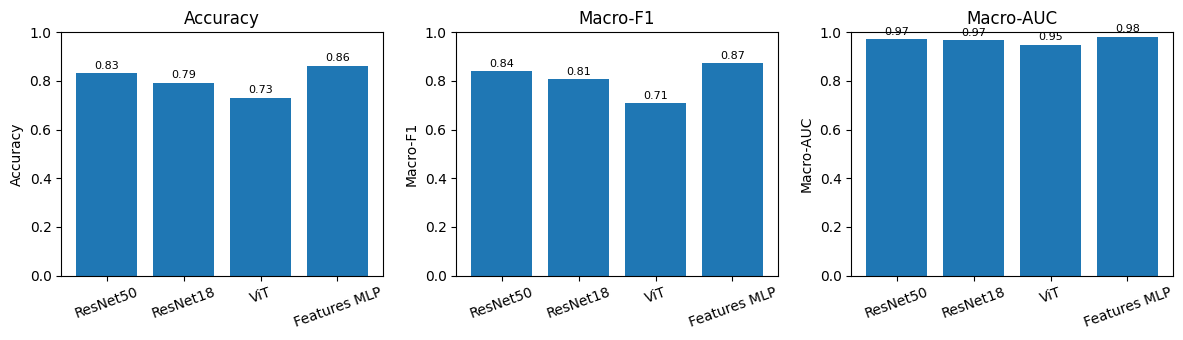

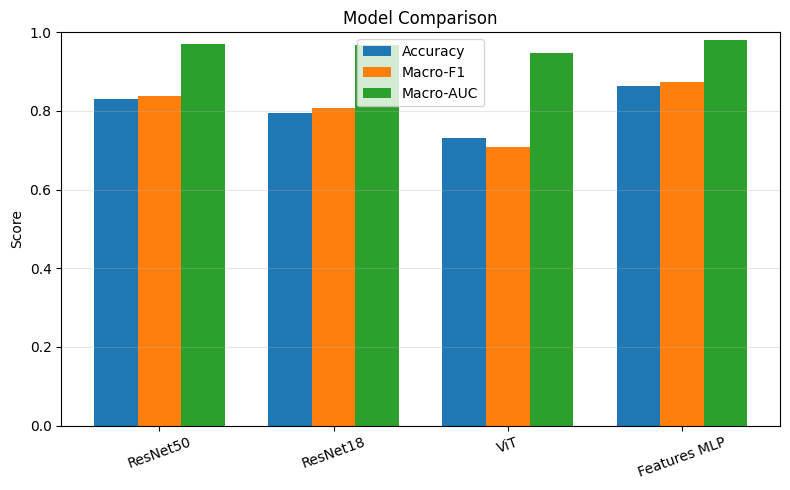

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_res = pd.DataFrame([
    {
        "Model": r["name"],
        "Accuracy": r["accuracy"],
        "Macro-F1": r["macro_f1"],
        "Macro-AUC": r["macro_auc"],
    }
    for r in results
])

print(df_res)

metrics = ["Accuracy", "Macro-F1", "Macro-AUC"]

plt.figure(figsize=(12, 3.5))

for i, metric in enumerate(metrics, 1):
    plt.subplot(1, 3, i)
    plt.bar(df_res["Model"], df_res[metric])
    plt.ylim(0, 1.0)
    plt.ylabel(metric)
    plt.xticks(rotation=20)
    plt.title(metric)
    for x, y in zip(df_res["Model"], df_res[metric]):
        plt.text(x, y + 0.01, f"{y:.2f}", ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()

x = np.arange(len(df_res["Model"]))  # model positions
width = 0.25

plt.figure(figsize=(8, 5))
plt.bar(x - width, df_res["Accuracy"], width, label="Accuracy")
plt.bar(x,         df_res["Macro-F1"], width, label="Macro-F1")
plt.bar(x + width, df_res["Macro-AUC"], width, label="Macro-AUC")

plt.xticks(x, df_res["Model"], rotation=20)
plt.ylim(0, 1.0)
plt.ylabel("Score")
plt.title("Model Comparison")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


Plotting confusion matrix for ResNet50...


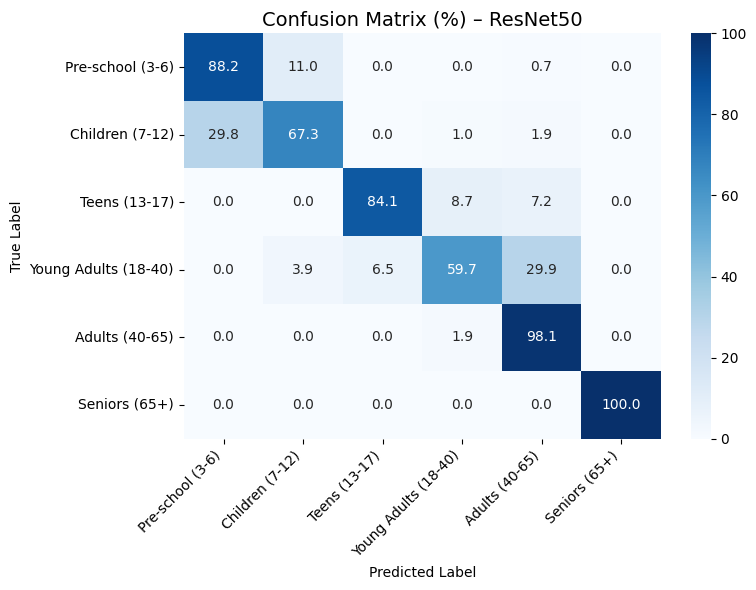

Plotting confusion matrix for ResNet18...


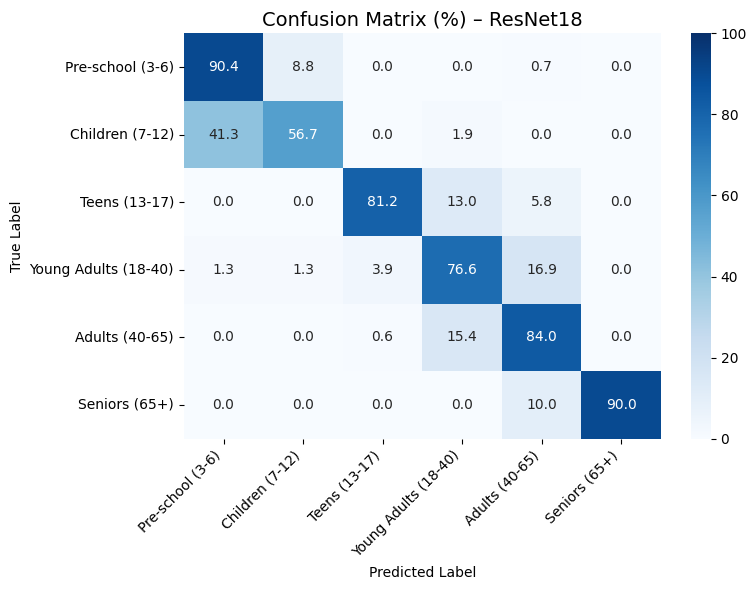

Plotting confusion matrix for ViT...


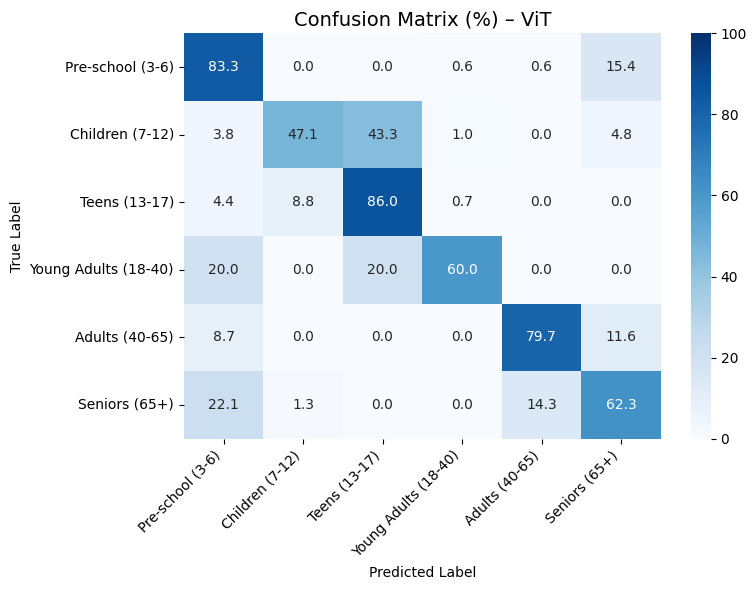

Plotting confusion matrix for Features MLP...


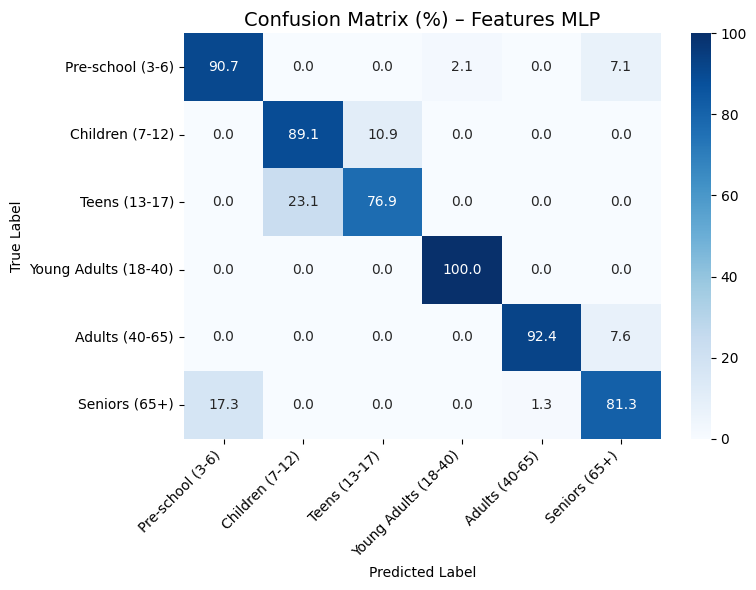

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

AGE_CLASSES = [
    "Pre-school (3-6)",
    "Children (7-12)",
    "Teens (13-17)",
    "Young Adults (18-40)",
    "Adults (40-65)",
    "Seniors (65+)",
]

def plot_confusion_matrix_percent(cm, labels, model_name):
    """
    cm: confusion matrix (numpy array)
    labels: list of class names
    """


    cm_percent = cm.astype(np.float64)
    row_sums = cm_percent.sum(axis=1, keepdims=True)
    cm_percent = np.divide(cm_percent, row_sums, out=np.zeros_like(cm_percent), where=row_sums!=0)
    cm_percent = cm_percent * 100  # convert to %

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm_percent,
        annot=True,
        fmt=".1f",
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels,
        cbar=True,
        vmin=0,
        vmax=100
    )

    plt.title(f"Confusion Matrix (%) – {model_name}", fontsize=14)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)

    plt.tight_layout()
    plt.show()



for r in results:
    cm = r["confusion_matrix"]
    name = r["name"]
    print(f"Plotting confusion matrix for {name}...")
    plot_confusion_matrix_percent(cm, AGE_CLASSES, model_name=name)


Loaded: (3672, 70)

Split column created. Unique values:
split
train    2579
val       562
test      531
Name: count, dtype: int64

Columns in df: ['inten_mean', 'inten_std', 'contrast_mean', 'contrast_std', 'edge_mean', 'edge_std', 'lap_var', 'curvature_mean', 'curvature_var', 'stroke_width_mean', 'stroke_width_var', 'shakiness', 'jerk', 'segments', 'gabor_0', 'gabor_1', 'gabor_2', 'gabor_3', 'gabor_4', 'gabor_5', 'gabor_6', 'gabor_7', 'orient_bin_0', 'orient_bin_1', 'orient_bin_2', 'orient_bin_3', 'orient_bin_4', 'orient_bin_5', 'orient_bin_6', 'orient_bin_7', 'hist_bin_0', 'hist_bin_1', 'hist_bin_2', 'hist_bin_3', 'hist_bin_4', 'hist_bin_5', 'hist_bin_6', 'hist_bin_7', 'hist_bin_8', 'hist_bin_9', 'hist_bin_10', 'hist_bin_11', 'hist_bin_12', 'hist_bin_13', 'hist_bin_14', 'hist_bin_15', 'hist_bin_16', 'hist_bin_17', 'hist_bin_18', 'hist_bin_19', 'hist_bin_20', 'hist_bin_21', 'hist_bin_22', 'hist_bin_23', 'hist_bin_24', 'hist_bin_25', 'hist_bin_26', 'hist_bin_27', 'hist_bin_28', 'hist_

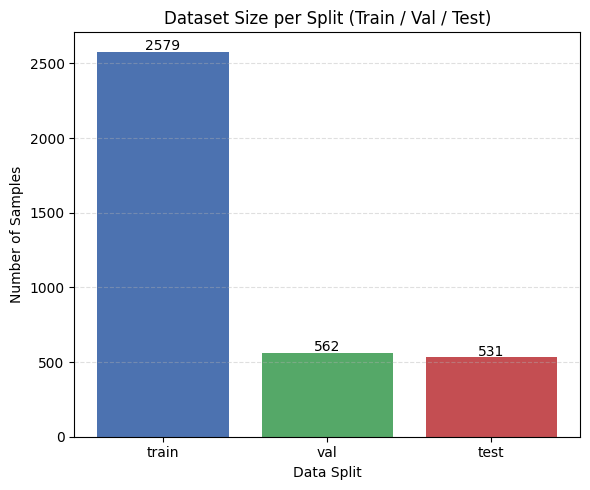


Overall split counts:
split
train    2579
val       562
test      531
Name: count, dtype: int64


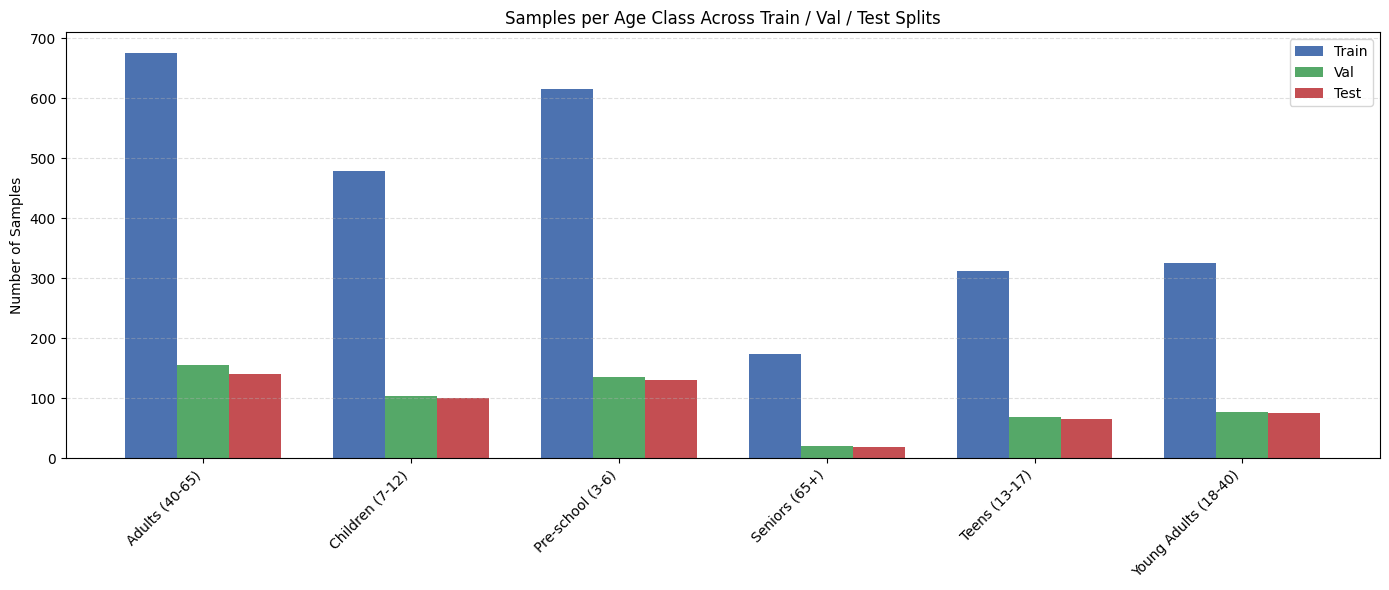


Per-class split distribution:
split                 train  val  test
age_class                             
Adults (40-65)          676  156   140
Children (7-12)         478  104   101
Pre-school (3-6)        615  136   130
Seniors (65+)           173   20    19
Teens (13-17)           312   69    66
Young Adults (18-40)    325   77    75


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np


MASTER = "/content/drive/MyDrive/DLCV_HW5/Dataset/master_features_augmented.csv"
df = pd.read_csv(MASTER)

print("Loaded:", df.shape)

def infer_split(p):
    if "/train/" in p:
        return "train"
    elif "/test/" in p:
        return "val"
    elif "/val/" in p:
        return "test"
    else:
        return "unknown"

df["split"] = df["img_path"].apply(infer_split)
print("\nSplit column created. Unique values:")
print(df["split"].value_counts())


print("\nColumns in df:", df.columns.tolist())
print(df.head())


split_order = ["train", "val", "test"]
split_counts = df["split"].value_counts().reindex(split_order)

plt.figure(figsize=(6, 5))
plt.bar(split_counts.index, split_counts.values, color=["#4C72B0", "#55A868", "#C44E52"])

plt.ylabel("Number of Samples")
plt.xlabel("Data Split")
plt.title("Dataset Size per Split (Train / Val / Test)")
plt.grid(axis="y", linestyle="--", alpha=0.4)

# annotate values
for x, y in zip(split_counts.index, split_counts.values):
    plt.text(x, y + 10, str(y), ha="center", fontsize=10)

plt.tight_layout()
plt.show()

print("\nOverall split counts:")
print(split_counts)

ct = pd.crosstab(df["age_class"], df["split"]).reindex(columns=split_order)

age_classes = ct.index.tolist()
x = np.arange(len(age_classes))
width = 0.25

plt.figure(figsize=(14, 6))
plt.bar(x - width, ct["train"], width=width, label="Train", color="#4C72B0")
plt.bar(x,         ct["val"],   width=width, label="Val",   color="#55A868")
plt.bar(x + width, ct["test"],  width=width, label="Test",  color="#C44E52")

plt.xticks(x, age_classes, rotation=45, ha="right")
plt.ylabel("Number of Samples")
plt.title("Samples per Age Class Across Train / Val / Test Splits")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

print("\nPer-class split distribution:")
print(ct)


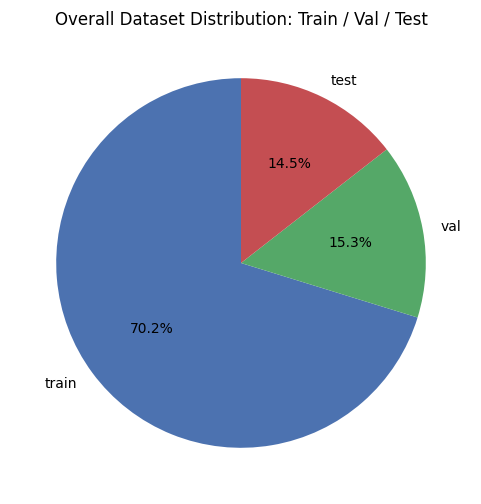


Overall split counts:
split
train    2579
val       562
test      531
Name: count, dtype: int64


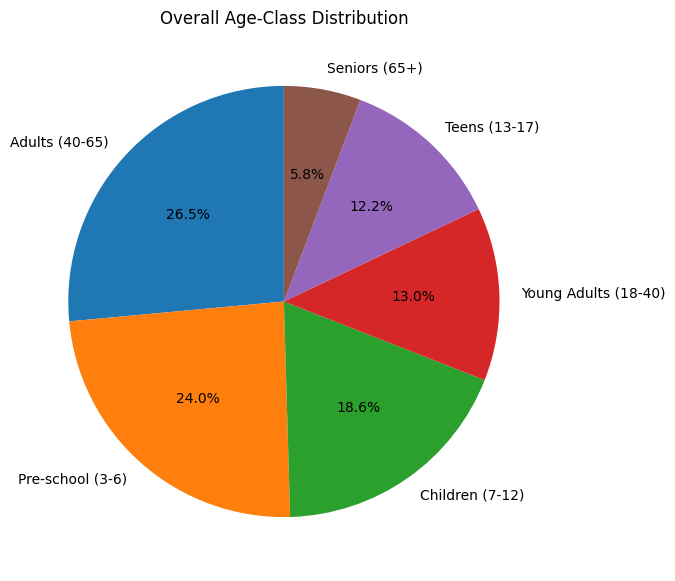


Age-class counts:
age_class
Adults (40-65)          972
Pre-school (3-6)        881
Children (7-12)         683
Young Adults (18-40)    477
Teens (13-17)           447
Seniors (65+)           212
Name: count, dtype: int64


In [12]:
import matplotlib.pyplot as plt
import pandas as pd


def infer_split(p):
    if "/train/" in p:
        return "train"
    elif "/test/" in p:
        return "val"
    elif "/val/" in p:
        return "test"
    else:
        return "unknown"

df["split"] = df["img_path"].apply(infer_split)


split_counts = df["split"].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(
    split_counts.values,
    labels=split_counts.index,
    autopct="%1.1f%%",
    startangle=90,
    colors=["#4C72B0", "#55A868", "#C44E52"]
)
plt.title("Overall Dataset Distribution: Train / Val / Test")
plt.show()

print("\nOverall split counts:")
print(split_counts)


age_counts = df["age_class"].value_counts()

plt.figure(figsize=(7, 7))
plt.pie(
    age_counts.values,
    labels=age_counts.index,
    autopct="%1.1f%%",
    startangle=90
)
plt.title("Overall Age-Class Distribution")
plt.show()

print("\nAge-class counts:")
print(age_counts)


In [13]:
import numpy as np
from sklearn.metrics import accuracy_score
import torch

def permutation_importance(model, X_test, y_test, device="cpu", n_repeats=5):
    """
    Compute permutation feature importance for an MLP classifier.
    Returns: importance scores for each feature.
    """
    model.eval()

    # Original accuracy
    X = torch.tensor(X_test, dtype=torch.float32).to(device)
    y = torch.tensor(y_test, dtype=torch.long).to(device)
    with torch.no_grad():
        preds = model(X).argmax(dim=1)
    base_acc = accuracy_score(y.cpu(), preds.cpu())

    print(f"Base accuracy: {base_acc:.4f}")

    importances = np.zeros(X_test.shape[1])

    # Loop through each feature
    for feat_idx in range(X_test.shape[1]):
        acc_drop_list = []

        # Repeat for stability
        for _ in range(n_repeats):
            X_perm = X_test.copy()
            np.random.shuffle(X_perm[:, feat_idx])  # shuffle one feature

            Xp = torch.tensor(X_perm, dtype=torch.float32).to(device)
            with torch.no_grad():
                preds = model(Xp).argmax(dim=1)
            acc = accuracy_score(y.cpu(), preds.cpu())

            acc_drop_list.append(base_acc - acc)

        # Mean accuracy drop = importance
        importances[feat_idx] = np.mean(acc_drop_list)

    return importances


Loaded: (3672, 70)
After cleaning: (3672, 71)
Classes: ['Adults (40-65)', 'Children (7-12)', 'Pre-school (3-6)', 'Seniors (65+)', 'Teens (13-17)', 'Young Adults (18-40)']
Original dim: 68 Expanded dim: 2346
Number of feature names: 2346
Train: (2579, 2346) Val: (562, 2346) Test: (531, 2346)
Device: cuda
Environment rebuilt. Model loaded successfully!
Base accuracy: 0.8625

Top 20 Most Important Features:
 1. orient_bin_5 skel_points                  importance=0.010546
 2. hist_bin_1 hist_bin_30                    importance=0.003390
 3. gabor_5 skel_junctions_ratio              importance=0.002637
 4. hist_bin_1 hist_bin_29                    importance=0.002637
 5. hist_bin_2 hist_bin_27                    importance=0.002637
 6. hist_bin_5 hist_bin_26                    importance=0.002637
 7. hist_bin_4 skel_points                    importance=0.002260
 8. hist_bin_3 hist_bin_26                    importance=0.002260
 9. hist_bin_2 hist_bin_30                    importance=0.00226

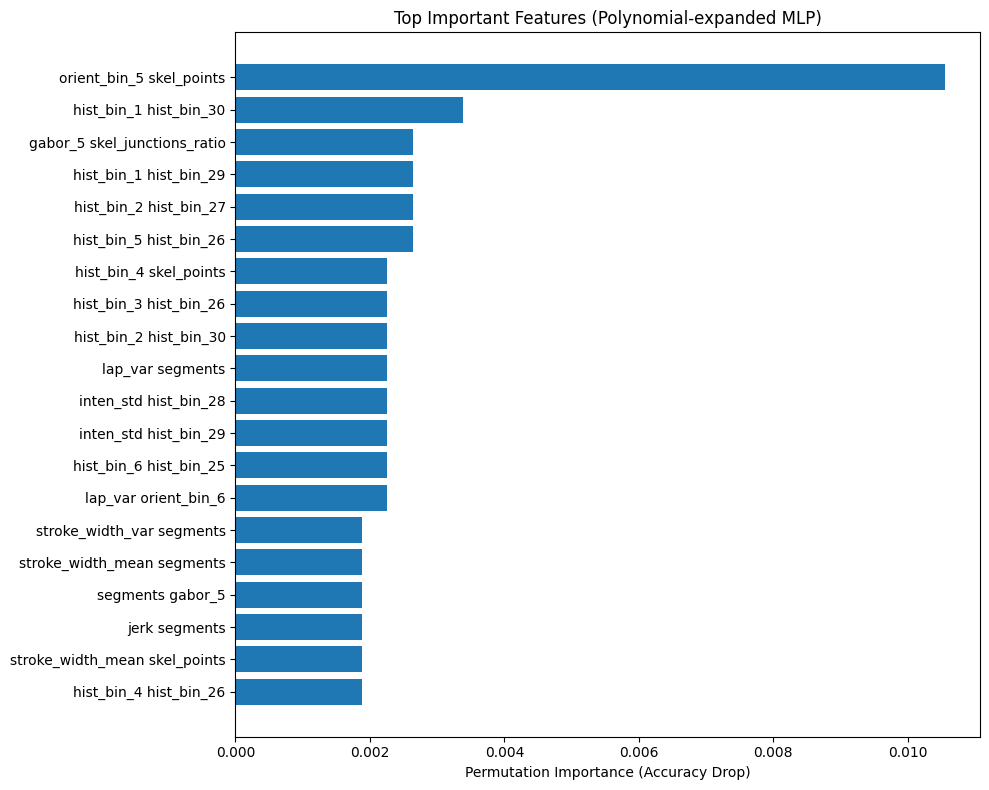

In [18]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

MASTER = "/content/drive/MyDrive/DLCV_HW5/Dataset/master_features_augmented.csv"
MODEL_PATH = "/content/drive/MyDrive/4995DLCV Final Project/best_mlp_poly_features.pt"

df = pd.read_csv(MASTER)
print("Loaded:", df.shape)

def infer_split(p):
    if "/train/" in p:
        return "train"
    elif "/test/" in p:
        return "val"
    elif "/val/" in p:
        return "test"
    else:
        return "unknown"

df["split"] = df["img_path"].apply(infer_split)

non_feature_cols = ["img_path", "age_class", "split"]
feature_cols = [c for c in df.columns if c not in non_feature_cols]

feat_df = df[feature_cols].replace([np.inf, -np.inf], np.nan)
mask_valid = ~feat_df.isna().any(axis=1)

df = df[mask_valid].reset_index(drop=True)
feat_df = feat_df[mask_valid].reset_index(drop=True)

print("After cleaning:", df.shape)

le = LabelEncoder()
df["label"] = le.fit_transform(df["age_class"])
num_classes = len(le.classes_)
print("Classes:", list(le.classes_))

X_raw = feat_df.values
y = df["label"].values
splits = df["split"].values

# Polynomial expansion
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
X_poly = poly.fit_transform(X_raw)
X = X_poly
input_dim = X.shape[1]

feature_names = poly.get_feature_names_out(feature_cols)
print("Original dim:", X_raw.shape[1], "Expanded dim:", X.shape[1])
print("Number of feature names:", len(feature_names))

X_train = X[splits == "train"]
y_train = y[splits == "train"]

X_val = X[splits == "val"]
y_val = y[splits == "val"]

X_test = X[splits == "test"]
y_test = y[splits == "test"]

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

class MLP(nn.Module):
    def __init__(self, in_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.net(x)

best_model = MLP(input_dim, num_classes).to(device)
best_model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
best_model.eval()

print("Environment rebuilt. Model loaded successfully!")

def permutation_importance(model, X_test, y_test, device="cpu", n_repeats=5):
    model.eval()

    X_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

    with torch.no_grad():
        base_preds = model(X_tensor).argmax(dim=1)
    base_acc = accuracy_score(y_test, base_preds.cpu().numpy())

    print(f"Base accuracy: {base_acc:.4f}")

    importances = np.zeros(X_test.shape[1])

    for feat_idx in range(X_test.shape[1]):
        drops = []
        for _ in range(n_repeats):
            X_perm = X_test.copy()
            np.random.shuffle(X_perm[:, feat_idx])

            Xp = torch.tensor(X_perm, dtype=torch.float32).to(device)
            with torch.no_grad():
                perm_preds = model(Xp).argmax(dim=1)

            acc = accuracy_score(y_test, perm_preds.cpu().numpy())
            drops.append(base_acc - acc)

        importances[feat_idx] = np.mean(drops)

    return importances

importances = permutation_importance(best_model, X_test_scaled, y_test, device=device)

idx_sorted = np.argsort(importances)[::-1]
topk = min(20, len(feature_names))

print(f"\nTop {topk} Most Important Features:")
for i in range(topk):
    feat = feature_names[idx_sorted[i]]
    score = importances[idx_sorted[i]]
    print(f"{i+1:2d}. {feat:40s}  importance={score:.6f}")

plt.figure(figsize=(10, 8))
plt.barh(range(topk), importances[idx_sorted[:topk]][::-1])
plt.yticks(range(topk), [feature_names[i] for i in idx_sorted[:topk]][::-1])
plt.xlabel("Permutation Importance (Accuracy Drop)")
plt.title("Top Important Features (Polynomial-expanded MLP)")
plt.tight_layout()
plt.show()
